<h1 align=center> EE6132 PROGRAMMING ASSIGNMENT 4 </h1>



<h2 align=center> LOADING IN DATA AND PREPROCESSING </h2>


In [1]:
!pip install numpy matplotlib scipy opencv-python plotly

In [2]:
# Importing required libraries...
import numpy as np
import cv2
import os
import scipy.io
import matplotlib.pyplot as plt

In [3]:
# Loading in the feature matches...
mat = scipy.io.loadmat('matchedPoints.mat')
matches = mat['matchedPoints']
# Loading in the intrinsics matrix...
K = scipy.io.loadmat('IntrinsicsMCV.mat')['IntrinsicMatrix']

In [4]:
print("The intrinsics matrix (for all views): \n\n",K)

The intrinsics matrix (for all views): 

 [[720.6605049    0.         420.22416865]
 [  0.         720.05791688 316.64872007]
 [  0.           0.           1.        ]]


- Let a matched point be $m_{ij} = [m^x_{ij} , m^y_{ij}]$ in image coordinates.
- To obtain $p_{ij} = [p^x_{ij} , p^y_{ij} ]$ in normalized camera coordinates, we perform the following operations : <br> \begin{align} p^x_{ij} = (m_x^{ij} −c_x)/f_x \\ p^y_{ij} = (m^y_{ij} −c_y)/f_y. \end{align} <br>
- Here $[c_x, c_y]$ is the principal point and $f_x$ and $f_y$ are the focal lengths. 

In [5]:
# Getting the focal lengths, and X and Y directional translations of the camera...
fx, fy, cx, cy = K[0, 0], K[1, 1], K[0, 2], K[1, 2]

print("Camera parameters : ", "\nfx =", fx, "\nfy=", fy, "\ncx=", cx, "\ncy=", cy)

def conv_Coords(K, matches):
    """
        Function to convert the image coordinates to normalized camera coordinates for compatibility.

        INPUTS:
                K - The camera intrinsic matrix of shape (3,3)
                matches - The array of feature matches.
        OUTPUTS:
    """
    # Initialiing an empty array for storing the output, same shape as matches...
    norm_coords = np.zeros(matches.shape)
    # Iterating over the feature matches...
    for i, matchset in enumerate(matches):
        # Computing the coordinates as given in the above markdown cell...
        norm_coords[i, 0], norm_coords[i, 1] = (matchset[0]-cx)/fx, (matchset[1]-cy)/fy
    # Returning the required output...
    return norm_coords

# Converting the image coordinates to normalized camera coordinates
norm_Coords = conv_Coords(K, matches)

Camera parameters :  
fx = 720.6605048966444 
fy= 720.0579168844923 
cx= 420.22416864692804 
cy= 316.64872007180253


<h2 align=center> BUNDLE ADJUSTMENT </h2>

We make two considerations here : 
- Small angle approximation i.e. $sin(\theta) ≈ θ$ and $cos(\theta) ≈ 1$. 
- As a result, the 3D rotation matrix for each view can be written as follows :
\begin{align}
R_i ≈ \begin{bmatrix} 1 & -\theta_i^z &  \theta_i^y \\ 
                      \theta_i^z & 1 &  -\theta_i^x \\ 
                      -\theta_i^y & \theta_i^x &  1 \\ 
\end{bmatrix} 
\end{align} <br>

- Here $\theta_i = [\theta_i^x,\theta_i^y,\theta_i^z]$, is the angular displacement of the camera in the $i^{th}$ view.

- Instead of solving for all the coordinates (X,Y and Z) of the 3-D points, we parametrize the points by their inverse depth reducing the number of unknowns and making the optimization much easier. 
- Specifically, if $(x_j , y_j )$ is the projection of the $j^{th}$ 3-D point in the reference frame , then the same $j^{th}$ 3-D point can be represented as \begin{align} P_j = \frac{1}{w_j} [x_j , y_j , 1]^T \end{align}
- Here, $w_j = \frac{1}{zj}$ is the inverse-depth of the $j^{th}$ 3-D point.

In [6]:
def create_R(angles, Nc):
    """
        Function to create the rotation matrices given the rotation angles
        
        INPUTS:
                angles - The angle vectors for all views of shape (Nc,3).
                Nc - The number of cameras/views currently used.
        OUTPUTS:
    """
    # Declaring R, the rotation matrix using given Nc..
    R = np.ones((Nc,3,3))
    # Getting the X, Y and Z rotations from the angles matrix. 
    rx, ry, rz = angles.T
    # Storing the rotation values in R as given in the above markdown cell...
    # NOTE: We use small angle approximation here...
    R[:,0,1], R[:,0,2] = -rz, ry
    R[:,1,0], R[:,1,2] = rz, -rx
    R[:,2,0], R[:,2,1] = -ry, rx
    
    # Returning the required rotation matrix
    return R

def reproject_2D(P, theta, T, Nc, Np):
    """
        Function to compute the reprojected camera coordinates (heterogeneous, normalized). 
        
        INPUTS:
                P - 3D points in world coordinates.
                theta - The rotation angle vectors.
                T - The translation vectors.
                Nc - The number of cameras/views currently used.
                NP - The number of feature matches.
        OUTPUTS:
                The reprojected 2D camera coordinates (heterogeneous).
    """
    if [type(P), type(theta), type(T)] != [np.ndarray]*3:
        raise TypeError("Please check input type! All inputs are numpy arrays.")
    
    # Getting the rotation matrix...
    R = create_R(theta, Nc)
    # Computing the the projected camera coordinates in homogeneous coordinates... 
    res = np.matmul(R , P.T) + T.reshape(Nc,3,1)
    # Dividing the X and Y coordiantes by the Z coordinate to convert to heterogeneous coordianates...
    res = res[:,:2,:]/res[:,2,:].reshape(Nc,1,Np)
    # Returning the reprojected point in hetrogeneous coordinates... 
    return res

- The projection of 3-D point $P_j$ in the $i^{th}$ image is $p_{ij} = [p^x_{ij}, p^y_{ij}]^T$. 
- And $\pi : \mathbb{R}^3 \rightarrow \mathbb{R}^2$ is the projection function i.e. $\pi([x, y, z]^T) = [x/z, y/z]^T$. 
- The cost function for bundle adjustment now becomes : 
\begin{equation}
F = \sum_{i=1}^{N_c} \sum_{j=1}^{N_p} \left||p_{ij} − \pi(R_iP_j +T_i)|\right|^2
\end{equation}
- Here $N_p$ is the number of 3-D points to reconstruct and $N_c$ is the number of views (or frames). 
- We the use the `scipy.optimize.least squares()` optimization routine to minimize F. 
- F is minimized with respect to the pose for each view and the inverse depth $w_j$ for each point.

In [7]:
def func_wrapper(x,**kwargs) :
    """
        Wrapper function to compute the residuals for least squares optimization. 
        
        INPUTS:
                x - The current feature vector.
        KWARGS:
                Nc - The number of cameras/views currently used.
                NP - The number of feature matches.
        OUTPUTS:
                The residuals for feature "x".
    """
    # Storing Nc and Np
    Nc = kwargs['Nc']
    Np = kwargs['Np']
        
    # Getting the depth values from the feature vector... 
    Ws = x[:Np]
    # Getting the angle vectors from the feature vector and reshaping to required shape... 
    angles = x[Np:Np+3*Nc].reshape(Nc,3)
    # Getting the translation vectors from the feature vector and reshaping to required shape... 
    Ts = x[Np+3*Nc:].reshape(Nc,3)
    
    # Getting the reference coordinates from normalied camera coords... 
    Ps = norm_Coords[:,:,0]
    # np.vstack(x,y) stacks x,y vertically. Check documentation for further clarifications...
    Ps = np.vstack(((Ps)[:,0]/Ws, (Ps[:,1]/Ws, np.ones(Np)/Ws))).T
    
    # Returning the residuals after computing them as in the pdf...
    return ((norm_Coords[:,:,:Nc] - reproject_2D(Ps, angles, Ts, Nc, Np).T)**2).ravel()

In [8]:
# Importing scipy.optimize for least squares optimization...
import scipy.optimize as opt

def Bundle_Adjust(matches, n_Views=None):
    """ 
        Function to compute the Depth, Rotation and Translation vectors using Bundle Adjustment. 
        
        INPUTS:
                matches - The (normalized) feature matches.
                n_Views - The number of cameras/views currently used.
        OUTPUTS:
                The optimal depth, rotation and translation vectors.
    """
    
    # Setting default number of camera views
    if n_Views is None:
        n_Views = matches.shape[2]
    
    # Storing the number of feature matches for ease...
    Np = matches.shape[0]   
    # The initial value of the feature vector as given in the pdf.
    x0 = np.hstack((np.ones(Np),np.zeros(n_Views*6)))
    
    # Getting the optimal feature vector using scipy.optimize.least_squares()...
    X_opt = opt.least_squares(func_wrapper , x0 = x0 ,verbose = 2, kwargs={'Nc':n_Views,'Np':Np})
    X_opt = X_opt['x']
    
    # Getting the optimal depth, rotation and translation vectors from the optimal feature vector...
    Ws = X_opt[:Np]
    angles = X_opt[Np:Np+3*n_Views].reshape(n_Views,3)
    Ts = X_opt[Np+3*n_Views:].reshape(n_Views,3)
    
    # Returning the required output...
    return Ws, angles, Ts

In [9]:
import plotly.graph_objs as graph

def plot_3D(W):
    """
        Wrapper function to visualize the 3D points given the depth. 
        
        INPUTS:
                W - The depth vector.
        PLOTS:
              The 3D points for visualization.
    """
    
    # Getting the sparse 3D point cloud...
    X,Y,Z = np.append(norm_Coords[:,:,0].T,np.ones((1,norm_Coords.shape[0])),axis=0)/W
    # Plotting the 3D cloud using plotly.graph_objs() and setting markersie to 2...
    plt_3D = graph.Figure(data=[graph.Scatter3d(x=X, y=Y, z=Z, mode= "markers", marker={"size":2})])
    # Showing the plot...
    plt_3D.show()

- We now plot a sparse 3-D point cloud for 5, 15
and 25 frames and observe the point cloud obtained in each case.

<h3 align=center> Bundle adjustment using 5 views </h3>

In [10]:
# Getting the optimal values for 5 views...
W5, angles5, T5 = Bundle_Adjust(norm_Coords, n_Views=5)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7854e-05                                    2.79e-03    
       1              2         1.2663e-05      5.19e-06       2.84e+01       4.83e-03    
       2              3         2.4807e-07      1.24e-05       2.84e+01       1.06e-04    
       3              4         3.2267e-08      2.16e-07       5.68e+01       1.89e-05    
       4              6         1.0538e-08      2.17e-08       2.84e+01       8.70e-06    
       5              8         6.8228e-10      9.86e-09       7.10e+00       9.21e-07    
       6              9         3.4974e-10      3.33e-10       1.42e+01       6.39e-07    
       7             11         8.4584e-11      2.65e-10       3.55e+00       1.64e-07    
       8             12         6.4584e-11      2.00e-11       7.10e+00       9.72e-08    
       9             13         5.2807e-11      1.18e-11       7.10e+00       9.85e-08    

- **In case of plotly display issues, please use Google Colab**

In [11]:
# Plotting for visualization...
plot_3D(W5)

<h3 align=center> Bundle adjustment using 15 views </h3>

In [12]:
# Getting the optimal values for 15 views...
W15, angles15, T15 = Bundle_Adjust(norm_Coords, n_Views=15)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.2726e-04                                    1.95e-02    
       1              3         3.3480e-05      3.94e-04       7.10e+00       2.48e-03    
       2              4         4.8273e-06      2.87e-05       1.42e+01       5.27e-04    
       3              6         1.4777e-06      3.35e-06       7.10e+00       2.16e-04    
       4              8         1.9515e-07      1.28e-06       1.78e+00       6.16e-05    
       5             10         2.0863e-08      1.74e-07       8.88e-01       1.23e-05    
       6             11         4.3787e-09      1.65e-08       1.78e+00       2.96e-06    
       7             13         6.3041e-10      3.75e-09       8.88e-01       4.12e-07    
       8             14         2.8441e-10      3.46e-10       1.78e+00       1.10e-07    
       9             16         2.3951e-10      4.49e-11       8.88e-01       9.80e-08    

In [13]:
# Plotting for visualization...
plot_3D(W15)

<h3 align=center> Bundle adjustment using all 25 views </h3>

In [14]:
# Getting the optimal values for all 25 views...
Ws, angles, Ts = Bundle_Adjust(norm_Coords)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1260e-03                                    3.58e-02    
       1              2         6.8971e-04      4.36e-04       2.84e+01       1.93e-02    
       2              3         1.5011e-05      6.75e-04       2.84e+01       1.53e-03    
       3              6         1.3170e-06      1.37e-05       3.55e+00       2.43e-04    
       4              7         1.1596e-06      1.57e-07       7.10e+00       1.89e-04    
       5              8         1.0257e-07      1.06e-06       1.78e+00       3.26e-05    
       6              9         7.4958e-09      9.51e-08       3.55e+00       4.02e-06    
       7             11         1.1916e-09      6.30e-09       1.78e+00       3.90e-07    
       8             13         7.9711e-10      3.95e-10       8.88e-01       6.50e-08    
       9             14         7.6134e-10      3.58e-11       1.78e+00       3.90e-08    

In [15]:
# Plotting for visualization...
plot_3D(Ws)

**The biggest differences observed as the number of views increased :**
- The depth values are more finetuned.
- The differences in depth (between the `G` and `F` shapes and the books in the background) are more pronounced.

<h2 align=center> PLANE SWEEP STEREO </h2>

- Minimizing F has provided us with the depths of a sparse set of 3-D points with respect the reference frame. 
- To obtain the dense depth reconstruction, we use the camera rotation matrices and translation vectors obtained from the bundle adjustment problem above along with the sequence provided in the shared folder in a plane-sweeping framework. 

In [16]:
# For storing the image sequence...
sequence = []

# Loading in the image sequence...
for img in os.listdir('./sequence/'):
    sequence.append(cv2.imread('./sequence/'+img))
    sequence[-1] = sequence[-1][:,:,::-1]

# Storing the number of views in Nc...
Nc = len(sequence)
# Storing the number of matches in Np...
Np = matches.shape[0]

In [17]:
# Some required libraries...
import matplotlib.animation as animation
from IPython.display import HTML

def view_Sequence(sequence):
    """
        Wrapper to visualize the image sequence.
        
        INPUTS:
            The image sequence.
        DISPLAYS:
            The sequence in animated form.
    """
    # Storing the number of frames...
    n_Frames = sequence.shape[0]
    
    # Getting the first animation frame...
    fig, ax = plt.subplots()
    frame = ax.imshow(sequence[0,:,:,:])
    plt.xticks([]), plt.yticks([])
    
    # Getting the subsequent animation frames...
    def next_Frame(i):
        img = sequence[i,:,:,:]
        frame.set_data(img)
        return frame
    
    # So that no value is returned...
    plt.close()
    # Generating the animation...
    anim = animation.FuncAnimation(fig, next_Frame, frames=n_Frames, repeat=False)  
    # Displaing the animation...
    display(HTML(anim.to_html5_video()))

In [18]:
# Visualizing the image sequence...
view_Sequence(np.array(sequence))

In [19]:
# Getting the minimum and maximum depths...
d_min, d_max = 1/Ws.max(), 1/Ws.min()
print("Minimum depth :",d_min, "\nMaximum depth:",d_max)

# The number of Depth Candidates
Nd = 10
# The depth candidate array
D = np.linspace(d_min, d_max, Nd)
print("\nCandidate Depths :",D)

H, W = sequence[0].shape[0], sequence[0].shape[1]

Minimum depth : 0.6732676108102246 
Maximum depth: 2.1728314193092277

Candidate Depths : [0.67326761 0.83988581 1.00650401 1.17312221 1.33974041 1.50635862
 1.67297682 1.83959502 2.00621322 2.17283142]


In [38]:
# Getting the rotation matrices from the optimal angles...
Rs = create_R(angles, Nc)
# Declaring "n" as in the pdf...
n = np.array([0,0,-1]).T
# Getting the inverse of the intrinsics matrix...
K_inv = np.linalg.inv(K)

In [21]:
# Converting the color images to grayscale for easier variance computation...
sequence_gray = [cv2.cvtColor(sequence[i], cv2.COLOR_BGR2GRAY) for i in range(Nc)]


- For the plane-sweep stereo algorithm, we next need to find the plane-induced homography. 
- For a plane at depth d and with normal vector n,
the plane-induced homography mapping the reference frame to the $i^{th}$ frame is given as:
\begin{align}
H_{d,i} = K [R_i − (\pmb{n} T_i^T)/d]K^{−1}
\end{align}

- As we are only concerned with the planes parallel to the reference frame, $n = [0, 0, −1]^T$ . K is the intrinsic matrix for the camera. 

In [31]:
def gen_depth_map(Nframes=None):
    """
        Function to generate the depth map.
        
        INPUTS:
              Nframes : The number of input frames considered.
        RETURNS:
              The depth map.
    """
    
    # Setting the number of frames to 25 if no value is specified...
    if Nframes is None:
        Nframes = Nc

    # Creating a 4D array(tensor) to store the homographies...
    warped_imgs = np.zeros((H,W, Nd, Nframes))

    # Iterating through the Nd depths and the number of frames considered...
    for i in range(Nd):
        for j in range(Nframes):
            # Computing the homography matrix as explained above...
            H_di = np.matmul(np.matmul(K, (Rs[j] - np.matmul(n, Ts[j])/D[i])),K_inv)

            # Applying the perpective transformation...
            warp = cv2.warpPerspective(sequence_gray[j], np.linalg.inv(H_di), dsize=(W,H))
            warped_imgs[:, :, i, j] = warp

    # Finding the variances across the frame axis...
    vars = np.var(warped_imgs, axis=3)
    # Finding argmin of variance for each pixel and creating the depth map...
    depth_map = D[np.argmin(vars, axis=2)]
    # Returning the depth map...
    return depth_map

def display_depth_map(depth_map, N):
    """
        Wrapper function to visualize the depth map.
        
        INPUTS:
              The depth map and N, the number of frames.
        DISPLAYS:
              The depth map.
    """
    # Plotting the original...
    plt.figure(figsize=(14,7))
    plt.subplot(1,2,1)
    plt.imshow(sequence[0], cmap='gray')
    plt.title("Original Image", fontsize = 16, color='white')
    # Plotting the depth map for N views...
    plt.subplot(1,2,2)
    plt.imshow(depth_map, cmap='gray')
    plt.title(f"Depth map for {N} frames", fontsize = 16, color='white')
    plt.show()

<h3 align=center> Depth map using 5 views </h3>

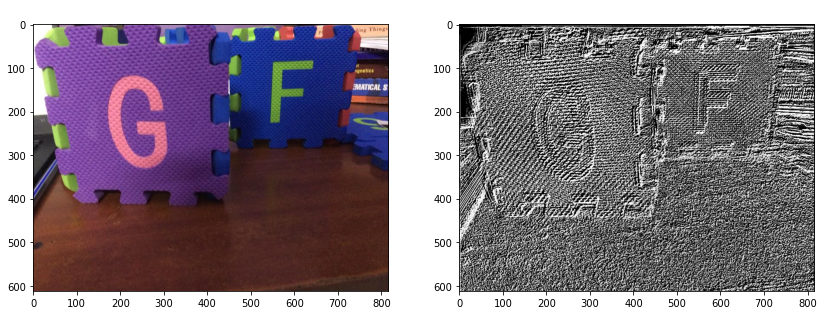

In [23]:
dmap = gen_depth_map(5)
display_depth_map(dmap, N=5)

<h3 align=center> Depth map using 15 views </h3>

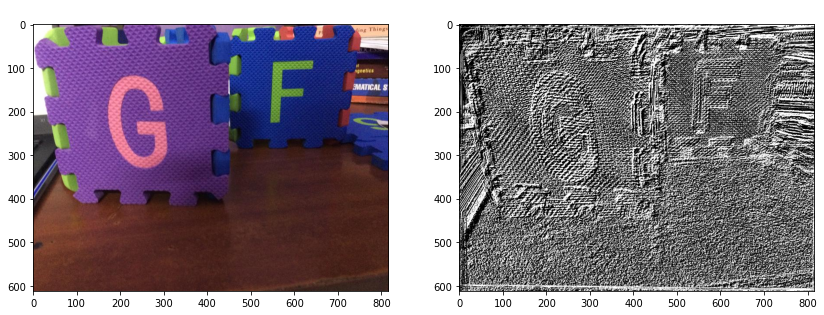

In [24]:
dmap = gen_depth_map(15)
display_depth_map(dmap, N=15)

<h3 align=center> Depth map using 25 views </h3>

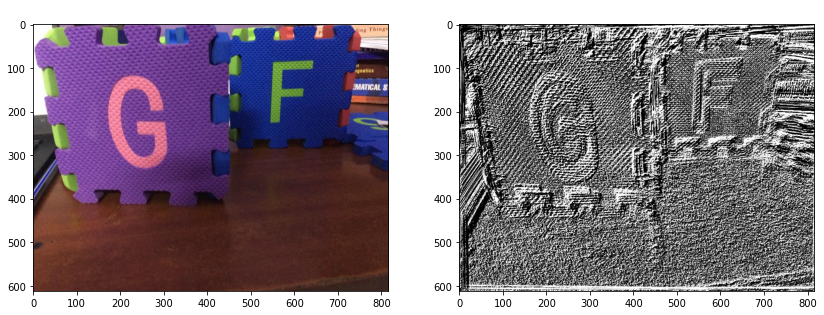

In [39]:
dmap = gen_depth_map(25)
display_depth_map(dmap, N=25)

- Increasing the number of frames improves the quality of the depth map reconstruction and reveals more texture.